In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers, models, regularizers
import cv2
import os
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
datasets = {
    0: '/content/drive/MyDrive/MLEE Project Dataset/healthy/',
    1: '/content/drive/MyDrive/MLEE Project Dataset/minimal/',
    2: '/content/drive/MyDrive/MLEE Project Dataset/moderate/',
    3: '/content/drive/MyDrive/MLEE Project Dataset/doubtful/',
    4: '/content/drive/MyDrive/MLEE Project Dataset/severe/'
}

# Preprocessing function with Gaussian Blur and Histogram Equalization
def preprocess_image(img, target_size=(128, 128)):
    # Resize the image to the target size
    img = cv2.resize(img, target_size)

    # Apply Gaussian Blur to reduce noise
    img = cv2.GaussianBlur(img, (3, 3), sigmaX=7)

    # Apply Histogram Equalization to improve contrast
    img = cv2.equalizeHist(img)

    # Subtract mean from the image to normalize
    img = img - np.mean(img)

    # Ensure all pixel values are non-negative
    img = np.maximum(img, 0)

    # Normalize to [0, 1] range
    img = img.astype('float32') / 255.0

    return img

# Load images and labels
def load_images_and_labels(folder_path, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = preprocess_image(img, target_size)
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load all data
combined_images, combined_labels = [], []
for class_label in range(5):
    path = datasets[class_label]
    images, labels = load_images_and_labels(path, class_label)
    combined_images.append(images)
    combined_labels.append(labels)

# Final dataset
x_data = np.concatenate(combined_images, axis=0)
y_data = np.concatenate(combined_labels, axis=0)
y_data_cat = to_categorical(y_data, num_classes=5)

# Shuffle
indices = np.arange(len(x_data))
np.random.shuffle(indices)
x_data = x_data[indices]
y_data_cat = y_data_cat[indices]
y_data = y_data[indices]

# Split
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data_cat, test_size=0.2, stratify=y_data, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1, stratify=np.argmax(y_train_val, axis=1), random_state=42)

# Print info
print(f"Training set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training set: (5947, 128, 128, 1), Validation set: (661, 128, 128, 1), Test set: (1652, 128, 128, 1)


In [ ]:
import numpy as np
from collections import Counter

# Convert one-hot encoded labels to class indices if necessary
if len(y_data.shape) > 1 and y_data.shape[1] > 1:
    y_labels = np.argmax(y_data, axis=1)
else:
    y_labels = y_data

# Count number of images per class
class_counts = Counter(y_labels)
for cls, count in sorted(class_counts.items()):
    print(f"Class {cls}: {count} images")

Class 0: 3253 images
Class 1: 2175 images
Class 2: 1086 images
Class 3: 1495 images
Class 4: 251 images


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert one-hot encoded labels into class indices
y_train_class_indices = np.argmax(y_train, axis=1)
y_val_class_indices = np.argmax(y_val, axis=1)
y_test_class_indices = np.argmax(y_test, axis=1)

# Create a standard ImageDataGenerator for augmentation
train_augmentor = ImageDataGenerator(
    rotation_range=20,  # Random rotations between 0 and 20 degrees
    width_shift_range=0.2,  # Shift image horizontally by 20%
    height_shift_range=0.2,  # Shift image vertically by 20%
    zoom_range=0.2,  # Zoom by 20%
    horizontal_flip=True,  # Flip image horizontally
    shear_range=0.2,  # Random shear transformations
    fill_mode='nearest'  # How to fill in pixels after transformation
)

# Validation generator (no augmentation, just rescaling)
val_augmentor = ImageDataGenerator()

# Train, validation, and test data generators
train_gen = train_augmentor.flow(x_train, y_train, batch_size=32)
val_gen = val_augmentor.flow(x_val, y_val, batch_size=32)
test_gen = val_augmentor.flow(x_test, y_test, batch_size=32, shuffle=False)

# Print the class distribution to ensure it's being used correctly
class_counts = np.bincount(y_train_class_indices)
print("Class distribution after augmentation:", class_counts)


Class distribution after augmentation: [2342 1566  782 1076  181]


In [ ]:
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust the shortcut dimensions if necessary
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(filters, kernel_size=1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_residual_model(input_shape=(128, 128, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Block 1
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Block 2
    x = residual_block(x, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
model = build_residual_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      2,112 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]  

 Total params: 290,693 (1.11 MB)

 Trainable params: 289,477 (1.10 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Build the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(train_gen,
                    epochs=50,
                    validation_data=val_gen,
                    callbacks=[early_stop, checkpoint, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3229 - loss: 1.5328

186/186 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.3231 - loss: 1.5325 - val_accuracy: 0.3933 - val_loss: 1.5058 - learning_rate: 0.0010
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4014 - loss: 1.3864 - val_accuracy: 0.4070 - val_loss: 1.5475 - learning_rate: 0.0010
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4189 - loss: 1.3303

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.4190 - loss: 1.3302 - val_accuracy: 0.4266 - val_loss: 1.4210 - learning_rate: 0.0010
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.4459 - loss: 1.2902 - val_accuracy: 0.3933 - val_loss: 2.2674 - learning_rate: 0.0010
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.4448 - loss: 1.2658 - val_accuracy: 0.2693 - val_loss: 1.5361 - learning_rate: 0.0010
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4671 - loss: 1.2482

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.4671 - loss: 1.2482 - val_accuracy: 0.4463 - val_loss: 1.2750 - learning_rate: 0.0010
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.4704 - loss: 1.2323 - val_accuracy: 0.2995 - val_loss: 1.6501 - learning_rate: 0.0010
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4630 - loss: 1.2284

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.4631 - loss: 1.2284 - val_accuracy: 0.4554 - val_loss: 1.2451 - learning_rate: 0.0010
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.4667 - loss: 1.2216 - val_accuracy: 0.4644 - val_loss: 1.2802 - learning_rate: 0.0010
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4850 - loss: 1.1937

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.4850 - loss: 1.1937 - val_accuracy: 0.5008 - val_loss: 1.2025 - learning_rate: 0.0010
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.4869 - loss: 1.1956 - val_accuracy: 0.3903 - val_loss: 1.4342 - learning_rate: 0.0010
Epoch 12/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4899 - loss: 1.1843

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.4899 - loss: 1.1843 - val_accuracy: 0.5023 - val_loss: 1.1770 - learning_rate: 0.0010
Epoch 13/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4822 - loss: 1.1774 - val_accuracy: 0.4009 - val_loss: 3.3819 - learning_rate: 0.0010
Epoch 14/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.4902 - loss: 1.1800 - val_accuracy: 0.4720 - val_loss: 1.2260 - learning_rate: 0.0010
Epoch 15/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4979 - loss: 1.1704

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.4979 - loss: 1.1704 - val_accuracy: 0.5356 - val_loss: 1.1122 - learning_rate: 0.0010
Epoch 16/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5000 - loss: 1.1667 - val_accuracy: 0.5083 - val_loss: 1.1366 - learning_rate: 0.0010
Epoch 17/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5030 - loss: 1.1623 - val_accuracy: 0.4281 - val_loss: 1.5330 - learning_rate: 0.0010
Epoch 18/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5127 - loss: 1.1475 - val_accuracy: 0.4902 - val_loss: 1.1860 - learning_rate: 0.0010
Epoch 19/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5091 - loss: 1.1493 - val_accuracy: 0.5446 - val_loss: 1.1463 - learning_rate: 0.0010
Epoch 20/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5098 - loss: 1.1289 - val_accuracy: 0.5265 - val_loss: 1.1487 - learning_rate: 0.0010
Epoch 21/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5112 - loss: 1

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5112 - loss: 1.1395 - val_accuracy: 0.5582 - val_loss: 1.0600 - learning_rate: 5.0000e-04
Epoch 22/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5174 - loss: 1.1305 - val_accuracy: 0.5068 - val_loss: 1.1729 - learning_rate: 5.0000e-04
Epoch 23/50
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5279 - loss: 1.1215

186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5279 - loss: 1.1214 - val_accuracy: 0.5658 - val_loss: 1.0495 - learning_rate: 5.0000e-04
Epoch 24/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.5219 - loss: 1.1093 - val_accuracy: 0.5840 - val_loss: 1.0554 - learning_rate: 5.0000e-04
Epoch 25/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.5384 - loss: 1.0999 - val_accuracy: 0.5446 - val_loss: 1.0725 - learning_rate: 5.0000e-04
Epoch 26/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.5297 - loss: 1.1123 - val_accuracy: 0.5673 - val_loss: 1.0706 - learning_rate: 5.0000e-04
Epoch 27/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5281 - loss: 1.1018 - val_accuracy: 0.4826 - val_loss: 1.2561 - learning_rate: 5.0000e-04
Epoch 28/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5192 - loss: 1.1133 - val_accuracy: 0.5189 - val_loss: 1.1368 - learning_rate: 5.0000e-04
Epoch 29/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - ac

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5393 - loss: 1.0908 - val_accuracy: 0.5658 - val_loss: 1.0380 - learning_rate: 2.5000e-04
Epoch 30/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5466 - loss: 1.0801 - val_accuracy: 0.5446 - val_loss: 1.0573 - learning_rate: 2.5000e-04
Epoch 31/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5413 - loss: 1.0739

186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5413 - loss: 1.0739 - val_accuracy: 0.5703 - val_loss: 1.0337 - learning_rate: 2.5000e-04
Epoch 32/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5408 - loss: 1.0686 - val_accuracy: 0.5552 - val_loss: 1.0342 - learning_rate: 2.5000e-04
Epoch 33/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5509 - loss: 1.0560

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5509 - loss: 1.0561 - val_accuracy: 0.5688 - val_loss: 1.0303 - learning_rate: 2.5000e-04
Epoch 34/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5455 - loss: 1.0617 - val_accuracy: 0.5416 - val_loss: 1.0449 - learning_rate: 2.5000e-04
Epoch 35/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5372 - loss: 1.0765 - val_accuracy: 0.5265 - val_loss: 1.1186 - learning_rate: 2.5000e-04
Epoch 36/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5500 - loss: 1.0609

186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5500 - loss: 1.0610 - val_accuracy: 0.5643 - val_loss: 1.0289 - learning_rate: 2.5000e-04
Epoch 37/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5588 - loss: 1.0468 - val_accuracy: 0.5567 - val_loss: 1.0360 - learning_rate: 2.5000e-04
Epoch 38/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5442 - loss: 1.0649

186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5442 - loss: 1.0649 - val_accuracy: 0.5809 - val_loss: 0.9958 - learning_rate: 2.5000e-04
Epoch 39/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5520 - loss: 1.0707 - val_accuracy: 0.5522 - val_loss: 1.0509 - learning_rate: 2.5000e-04
Epoch 40/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5538 - loss: 1.0482 - val_accuracy: 0.5537 - val_loss: 1.0364 - learning_rate: 2.5000e-04
Epoch 41/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5419 - loss: 1.0607 - val_accuracy: 0.5613 - val_loss: 1.0128 - learning_rate: 2.5000e-04
Epoch 42/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5556 - loss: 1.0514 - val_accuracy: 0.5598 - val_loss: 1.0157 - learning_rate: 2.5000e-04
Epoch 43/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5512 - loss: 1.0560 - val_accuracy: 0.5477 - val_loss: 1.0694 - learning_rate: 2.5000e-04
Epoch 44/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - a

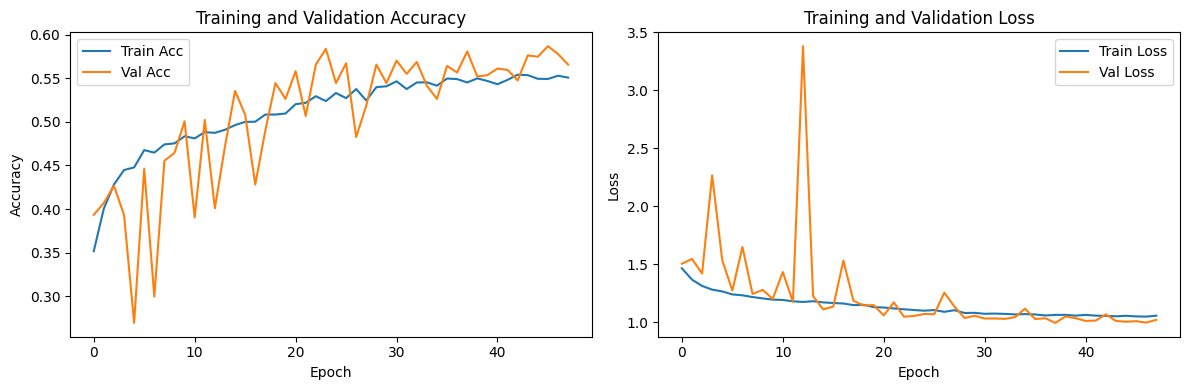

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
def plot_training(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)


In [ ]:
from sklearn.metrics import classification_report, cohen_kappa_score

# Get true labels and predictions
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(x_val), axis=1)

y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model.predict(x_test), axis=1)

# Classification report
print("📌 Validation Classification Report:")
print(classification_report(y_val_true, y_val_pred))

print("📌 Test Classification Report:")
print(classification_report(y_test_true, y_test_pred))

# Cohen's Kappa
kappa_val = cohen_kappa_score(y_val_true, y_val_pred)
kappa_test = cohen_kappa_score(y_test_true, y_test_pred)

print(f"Validation Cohen's Kappa: {kappa_val:.4f}")
print(f"Test Cohen's Kappa: {kappa_test:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
📌 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.90      0.69       260
           1       0.56      0.48      0.52       174
           2       0.68      0.60      0.63        87
           3       0.00      0.00      0.00       120
           4       0.79      0.75      0.77        20

    accuracy                           0.58       661
   macro avg       0.52      0.54      0.52       661
weighted avg       0.48      0.58      0.51       661

📌 Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.89      0.68       651
           1       0.49      0.43      0.46       435
           2       0.72      0.56      0.63       217
           3       0.00      0.00      0.00       299
           4       0.69      0.72      0.71        50

    accuracy                           

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


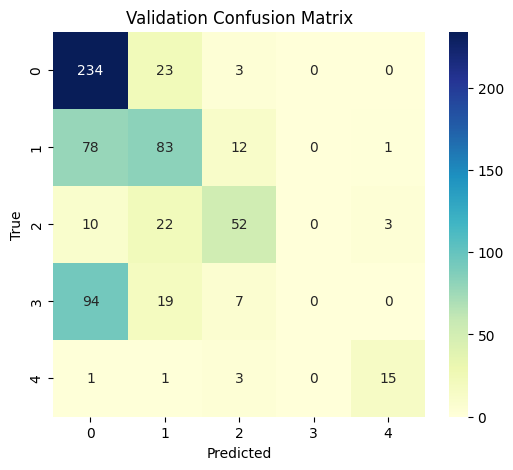

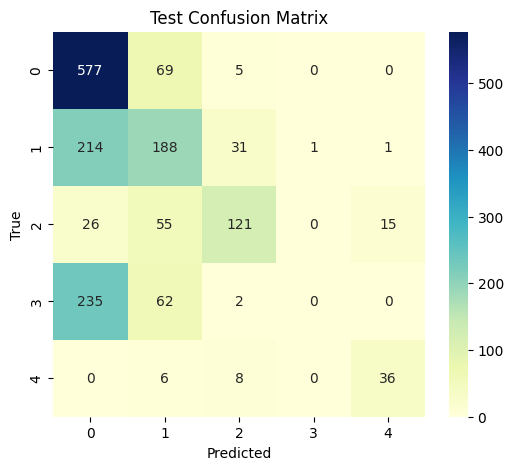

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=[0, 1, 2, 3, 4],
                yticklabels=[0, 1, 2, 3, 4])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion(y_val_true, y_val_pred, "Validation Confusion Matrix")
plot_confusion(y_test_true, y_test_pred, "Test Confusion Matrix")


In [ ]:
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust the shortcut dimensions if necessary
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(filters, kernel_size=1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_residual_model(input_shape=(128, 128, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # VGG-like Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # MaxPooling layer after VGG-like block

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Block 1
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Block 2
    x = residual_block(x, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
model = build_residual_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     18,464 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     18,496 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │      2,112 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ activation_2[0][

 Total params: 346,405 (1.32 MB)

 Trainable params: 345,189 (1.32 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Build the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(train_gen,
                    epochs=50,
                    validation_data=val_gen,
                    callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3360 - loss: 1.5593

186/186 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.3361 - loss: 1.5589 - val_accuracy: 0.3903 - val_loss: 1.4464 - learning_rate: 0.0010
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.3790 - loss: 1.4104 - val_accuracy: 0.1331 - val_loss: 2.8329 - learning_rate: 0.0010
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.3985 - loss: 1.3734 - val_accuracy: 0.2799 - val_loss: 1.5094 - learning_rate: 0.0010
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4365 - loss: 1.3088

186/186 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.4365 - loss: 1.3088 - val_accuracy: 0.4675 - val_loss: 1.2484 - learning_rate: 0.0010
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.4429 - loss: 1.2772 - val_accuracy: 0.4100 - val_loss: 1.2965 - learning_rate: 0.0010
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.4424 - loss: 1.2691 - val_accuracy: 0.3540 - val_loss: 1.3004 - learning_rate: 0.0010
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4819 - loss: 1.2175 - val_accuracy: 0.1362 - val_loss: 2.3270 - learning_rate: 0.0010
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4802 - loss: 1.2056

186/186 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.4802 - loss: 1.2056 - val_accuracy: 0.5250 - val_loss: 1.1248 - learning_rate: 0.0010
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4884 - loss: 1.1813 - val_accuracy: 0.5129 - val_loss: 1.1775 - learning_rate: 0.0010
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.4819 - loss: 1.1869 - val_accuracy: 0.5295 - val_loss: 1.1365 - learning_rate: 0.0010
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5045 - loss: 1.1545

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5045 - loss: 1.1545 - val_accuracy: 0.5310 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 12/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5152 - loss: 1.1521

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5151 - loss: 1.1521 - val_accuracy: 0.5552 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 13/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5076 - loss: 1.1410 - val_accuracy: 0.5477 - val_loss: 1.0929 - learning_rate: 0.0010
Epoch 14/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5103 - loss: 1.1447 - val_accuracy: 0.5401 - val_loss: 1.1382 - learning_rate: 0.0010
Epoch 15/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.5256 - loss: 1.1106 - val_accuracy: 0.5159 - val_loss: 1.1214 - learning_rate: 0.0010
Epoch 16/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5196 - loss: 1.1210 - val_accuracy: 0.5340 - val_loss: 1.0755 - learning_rate: 0.0010
Epoch 17/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.5255 - loss: 1.1101 - val_accuracy: 0.5658 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 18/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5404 - loss: 1

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5403 - loss: 1.0793 - val_accuracy: 0.5719 - val_loss: 1.0039 - learning_rate: 5.0000e-04
Epoch 19/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5299 - loss: 1.0940 - val_accuracy: 0.5688 - val_loss: 1.0140 - learning_rate: 5.0000e-04
Epoch 20/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5369 - loss: 1.0643 - val_accuracy: 0.5643 - val_loss: 1.0491 - learning_rate: 5.0000e-04
Epoch 21/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5409 - loss: 1.0734 - val_accuracy: 0.5507 - val_loss: 1.0656 - learning_rate: 5.0000e-04
Epoch 22/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5529 - loss: 1.0631 - val_accuracy: 0.5204 - val_loss: 1.1125 - learning_rate: 5.0000e-04
Epoch 23/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5441 - loss: 1.0690 - val_accuracy: 0.5416 - val_loss: 1.0602 - learning_rate: 5.0000e-04
Epoch 24/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - ac

186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.5470 - loss: 1.0736 - val_accuracy: 0.5779 - val_loss: 0.9918 - learning_rate: 2.5000e-04
Epoch 25/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5645 - loss: 1.0370

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5645 - loss: 1.0371 - val_accuracy: 0.5946 - val_loss: 0.9750 - learning_rate: 2.5000e-04
Epoch 26/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5320 - loss: 1.0650 - val_accuracy: 0.5507 - val_loss: 1.0416 - learning_rate: 2.5000e-04
Epoch 27/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5530 - loss: 1.0502 - val_accuracy: 0.5688 - val_loss: 1.0182 - learning_rate: 2.5000e-04
Epoch 28/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5542 - loss: 1.0516 - val_accuracy: 0.5688 - val_loss: 1.0071 - learning_rate: 2.5000e-04
Epoch 29/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.5508 - loss: 1.0533 - val_accuracy: 0.5779 - val_loss: 0.9812 - learning_rate: 2.5000e-04
Epoch 30/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.5480 - loss: 1.0492 - val_accuracy: 0.5794 - val_loss: 0.9854 - learning_rate: 2.5000e-04
Epoch 31/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - a

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5535 - loss: 1.0430 - val_accuracy: 0.5915 - val_loss: 0.9699 - learning_rate: 1.2500e-04
Epoch 33/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5638 - loss: 1.0289 - val_accuracy: 0.5749 - val_loss: 0.9839 - learning_rate: 1.2500e-04
Epoch 34/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5601 - loss: 1.0297 - val_accuracy: 0.5855 - val_loss: 0.9712 - learning_rate: 1.2500e-04
Epoch 35/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5585 - loss: 1.0231 - val_accuracy: 0.5779 - val_loss: 0.9797 - learning_rate: 1.2500e-04
Epoch 36/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5689 - loss: 1.0294 - val_accuracy: 0.5794 - val_loss: 0.9745 - learning_rate: 1.2500e-04
Epoch 37/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.5650 - loss: 1.0283 - val_accuracy: 0.5779 - val_loss: 0.9789 - learning_rate: 1.2500e-04
Epoch 38/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - ac

186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5661 - loss: 1.0069 - val_accuracy: 0.5840 - val_loss: 0.9670 - learning_rate: 6.2500e-05
Epoch 39/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5696 - loss: 1.0134 - val_accuracy: 0.5734 - val_loss: 0.9882 - learning_rate: 6.2500e-05
Epoch 40/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5576 - loss: 1.0242

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.5576 - loss: 1.0242 - val_accuracy: 0.5840 - val_loss: 0.9639 - learning_rate: 6.2500e-05
Epoch 41/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5760 - loss: 1.0018

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5760 - loss: 1.0018 - val_accuracy: 0.5900 - val_loss: 0.9610 - learning_rate: 6.2500e-05
Epoch 42/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5651 - loss: 1.0306 - val_accuracy: 0.5719 - val_loss: 0.9776 - learning_rate: 6.2500e-05
Epoch 43/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.5602 - loss: 1.0282 - val_accuracy: 0.5703 - val_loss: 0.9757 - learning_rate: 6.2500e-05
Epoch 44/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.5741 - loss: 1.0168 - val_accuracy: 0.5749 - val_loss: 0.9737 - learning_rate: 6.2500e-05
Epoch 45/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5784 - loss: 1.0196

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5783 - loss: 1.0197 - val_accuracy: 0.5930 - val_loss: 0.9608 - learning_rate: 6.2500e-05
Epoch 46/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5624 - loss: 1.0122

186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5624 - loss: 1.0122 - val_accuracy: 0.5900 - val_loss: 0.9560 - learning_rate: 6.2500e-05
Epoch 47/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5648 - loss: 1.0280 - val_accuracy: 0.5809 - val_loss: 0.9723 - learning_rate: 6.2500e-05
Epoch 48/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5545 - loss: 1.0298 - val_accuracy: 0.5749 - val_loss: 0.9806 - learning_rate: 6.2500e-05
Epoch 49/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5723 - loss: 1.0153 - val_accuracy: 0.5885 - val_loss: 0.9626 - learning_rate: 6.2500e-05
Epoch 50/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.5686 - loss: 1.0099 - val_accuracy: 0.5930 - val_loss: 0.9593 - learning_rate: 6.2500e-05


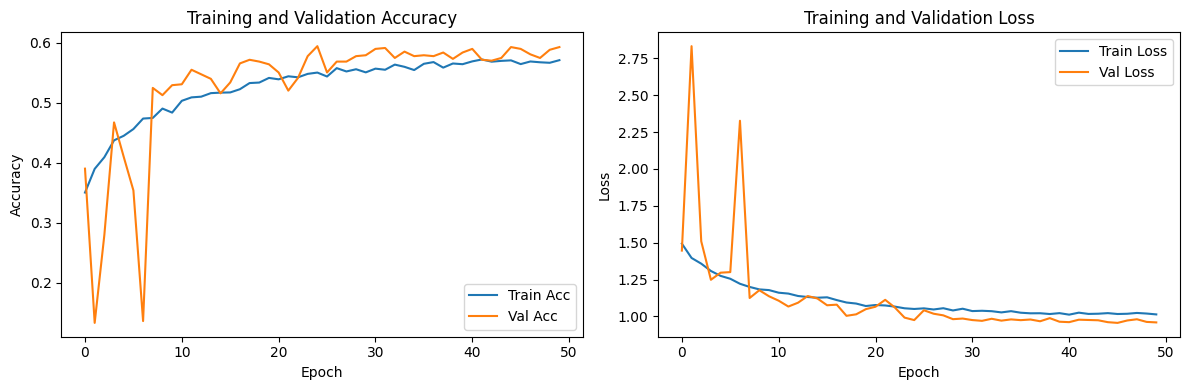

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
def plot_training(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)


In [ ]:
from sklearn.metrics import classification_report, cohen_kappa_score

# Get true labels and predictions
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(x_val), axis=1)

y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model.predict(x_test), axis=1)

# Classification report
print("📌 Validation Classification Report:")
print(classification_report(y_val_true, y_val_pred))

print("📌 Test Classification Report:")
print(classification_report(y_test_true, y_test_pred))

# Cohen's Kappa
kappa_val = cohen_kappa_score(y_val_true, y_val_pred)
kappa_test = cohen_kappa_score(y_test_true, y_test_pred)

print(f"Validation Cohen's Kappa: {kappa_val:.4f}")
print(f"Test Cohen's Kappa: {kappa_test:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
📌 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.86      0.70       260
           1       0.51      0.51      0.51       174
           2       0.70      0.71      0.70        87
           3       0.00      0.00      0.00       120
           4       0.88      0.75      0.81        20

    accuracy                           0.59       661
   macro avg       0.54      0.57      0.55       661
weighted avg       0.48      0.59      0.53       661

📌 Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.84      0.70       651
           1       0.50      0.54      0.52       435
           2       0.69      0.64      0.66       217
           3       1.00      0.00      0.01       299
           4       0.69      0.84      0.76        50

    accuracy                           

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


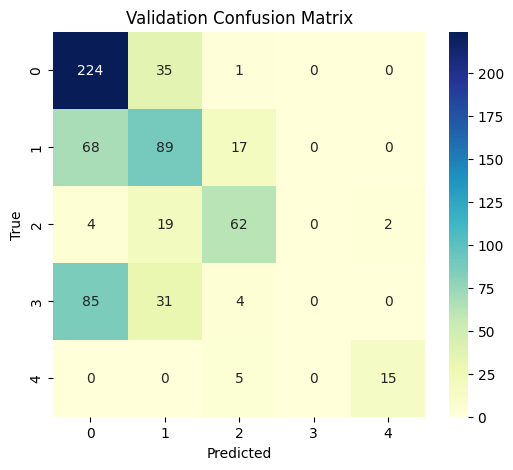

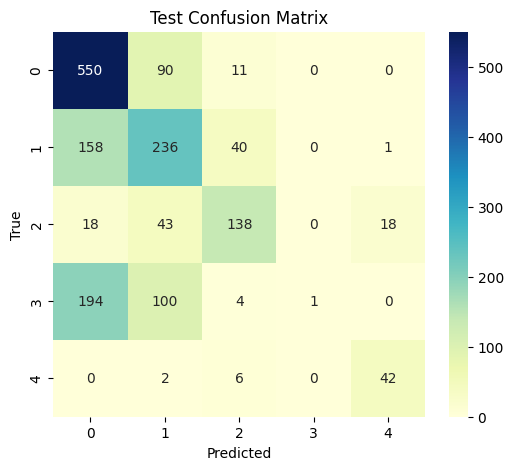

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=[0, 1, 2, 3, 4],
                yticklabels=[0, 1, 2, 3, 4])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion(y_val_true, y_val_pred, "Validation Confusion Matrix")
plot_confusion(y_test_true, y_test_pred, "Test Confusion Matrix")
